<a href="https://colab.research.google.com/github/Egoago/AIT-Assignment-II/blob/main/AIT_Deep_learning_Assigment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright

<PRE>
Copyright (c) 2021 Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Use this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Author classification
The task is to train a 1D CNN or an LSTM that is able to  classify text from two authors. The final model should be able to tell about a text with a given length (e.g. 60 characters) who wrote it. 

Please write the codes according to the following parts:

## Python module imports
Import all Python modules that you would need during the Assignment.

In [1]:
import numpy as np
import keras
import string
import gc
import pandas
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import GlorotNormal
from urllib.request import urlretrieve, urlopen
from collections import Counter, OrderedDict
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Data acquisition
Seek a possible dataset, you can use any source, e.g.
* http://www.gutenberg.org/
* https://www.kaggle.com/datasets
* https://paperswithcode.com/datasets
* if you would like to learn Hungarian, than e.g. https://mek.oszk.hu/

You can download the text by hand (e.g. by copy-pasting some parts into txt files) or with Python. 

Number of characters from Austen: 1331583
Number of characters from Shakespeare: 1376978


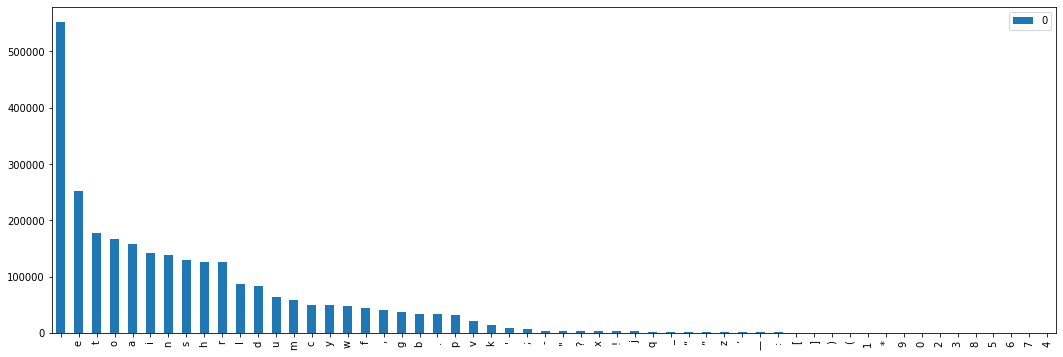

In [2]:
def loadText(url):
  file = urlopen("http://www.gutenberg.org/"+url)
  text = file.read().decode('utf-8').lower()
  file.close()
  text = text[2500:len(text)-20000] #the beginning end of the texts contains no relevant information
  return text

# Books from Jane Austen
jane = loadText("cache/epub/42671/pg42671.txt")  #Pride and Prejudice
jane += loadText("files/161/161-0.txt")          #Sense and Sensibility
# Books from William Shakespeare
william = loadText("cache/epub/1121/pg1121.txt") #As You Like It
william += loadText("cache/epub/1118/pg1118.txt")#Much Ado About Nothing
william += loadText("cache/epub/1795/pg1795.txt")#Macbeth
william += loadText("cache/epub/1107/pg1107.txt")#Taming of The Shrew
william += loadText("cache/epub/1135/pg1135.txt")#Tempest
william += loadText("cache/epub/1787/pg1787.txt")#Hamlet
william += loadText("cache/epub/1785/pg1785.txt")#Julius Caesar
william += loadText("cache/epub/1114/pg1114.txt")#The Merchant of Venice
william += loadText("cache/epub/1108/pg1108.txt")#The Two Gentlemen of Verona
william += loadText("cache/epub/1793/pg1793.txt")#Othello
william += loadText("cache/epub/1125/pg1125.txt")#All's Well That Ends Well

letter_counts = OrderedDict(Counter(jane + william).most_common()) #count character distribution
df = pandas.DataFrame.from_dict(letter_counts, orient='index')
rareChars = df.loc[(df[0]<200)] #rare, unsignificant characters
for c in rareChars.index: #keep numbers, no matter how rare they are
  if c in string.digits:
    rareChars = rareChars.drop(c)
for c in list(rareChars.index)+list(['\n','\r']): #delete unwanted characters
  df = df.drop(c)
  jane = jane.replace(c,'')
  william = william.replace(c,'')

print('Number of characters from Austen:', len(jane))
print('Number of characters from Shakespeare:', len(william))
df.plot(kind='bar', figsize = (18,6));

## Data loading, labeling and preprocessing
Load the data and convert the characters into one-hot encodings. Then load the data into a 3D NumPy array, with a shape of

* (batch, sequence_length, alphabet_length)

where sequence_length=60, and alphabet_length equals to the number of unique characters in both datasets. The sequences should be cut out from the complete dataset by sliding window. You should add 0 and 1 labels to the sequences, according to the author. 

Later you may change sequence_length to achieve better results!

In [3]:
chars = sorted(list(set(jane + william)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))
num_author = {0: "Jane Austen", 1: "William Shakespeare"}
author_num = {"Jane Austen" : 0, "William Shakespeare": 1}
alphabet_length = len(chars)

sequence_length = 90
step = 18
sentences  = []
author = [] # 0 - jane 1 - william
#cut out sentences and label them
for i in range(0, len(jane)-sequence_length, step):
    sentences.append(jane[i:i+sequence_length])
    author.append(author_num["Jane Austen"])
del jane
for i in range(0, len(william)-sequence_length, step):
    sentences.append(william[i:i+sequence_length])
    author.append(author_num["William Shakespeare"])
del william #important, because of insufficient CPU RAM

batches = len(sentences)
p = np.random.default_rng(1).permutation(batches)  #shuffle with indexes, this is a more memory efficent way than sklearn
#need to shuffle before splitting
X = np.zeros((batches, sequence_length, alphabet_length))
Y = np.zeros(batches)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence): 
        X[p[i],t,char_indices[char]] = 1  #one-hot encoding
        Y[p[i]] = author[i]               #just copying labels with shuffling in mind

del author
del sentences
gc.collect() #memory preservation again..

print ("Shape of the input data:", X.shape)
print ("Shape of the target data:", Y.shape)

Shape of the input data: (150466, 90, 56)
Shape of the target data: (150466,)


## Data splitting
Split the data into train, validate and test sets.

In [4]:
valid_split = 0.1
test_split  = 0.1

v_point = int(batches*(1-valid_split-test_split))
t_point = int(batches*(1-test_split))

X_train = X[0:v_point]
Y_train = Y[0:v_point]
X_valid = X[v_point: t_point]
Y_valid = Y[v_point: t_point]
X_test  = X[t_point:]
Y_test  = Y[t_point:]
del X
del Y
gc.collect();  #and again..

## Model definition
Define a 1D CNN or an LSTM for the task. Compile the model with the correct loss function.

Trainable variables: 94849


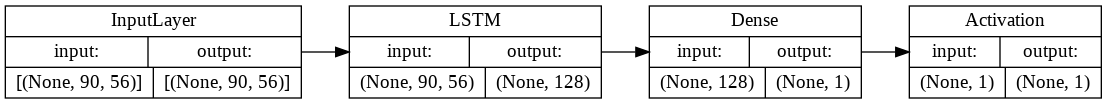

In [5]:
model = Sequential()
#tried CNN and biderictional layers as well, but LSTM turned out to be the best
model.add(LSTM(128, input_shape=(X_train.shape[-2], X_train.shape[-1])))
model.add(Dense(1, kernel_initializer=GlorotNormal()))
model.add(Activation("sigmoid"))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(f'Trainable variables: {np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])}') 
keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, rankdir='LR') #I just like this representation better

## Model training
Train the model and apply early stopping.

Epoch 1/100
236/236 - 29s - loss: 0.2719 - accuracy: 0.8978 - val_loss: 0.2049 - val_accuracy: 0.9325
Epoch 2/100
236/236 - 4s - loss: 0.1917 - accuracy: 0.9411 - val_loss: 0.1628 - val_accuracy: 0.9547
Epoch 3/100
236/236 - 4s - loss: 0.1345 - accuracy: 0.9605 - val_loss: 0.1171 - val_accuracy: 0.9652
Epoch 4/100
236/236 - 4s - loss: 0.1078 - accuracy: 0.9676 - val_loss: 0.0951 - val_accuracy: 0.9708
Epoch 5/100
236/236 - 4s - loss: 0.0821 - accuracy: 0.9719 - val_loss: 0.0883 - val_accuracy: 0.9743
Epoch 6/100
236/236 - 4s - loss: 0.0501 - accuracy: 0.9838 - val_loss: 0.0371 - val_accuracy: 0.9894
Epoch 7/100
236/236 - 4s - loss: 0.0361 - accuracy: 0.9892 - val_loss: 0.0378 - val_accuracy: 0.9925
Epoch 8/100
236/236 - 4s - loss: 0.0328 - accuracy: 0.9909 - val_loss: 0.0292 - val_accuracy: 0.9907
Epoch 9/100
236/236 - 4s - loss: 0.0229 - accuracy: 0.9935 - val_loss: 0.0224 - val_accuracy: 0.9934
Epoch 10/100
236/236 - 4s - loss: 0.0210 - accuracy: 0.9944 - val_loss: 0.0639 - val_accur

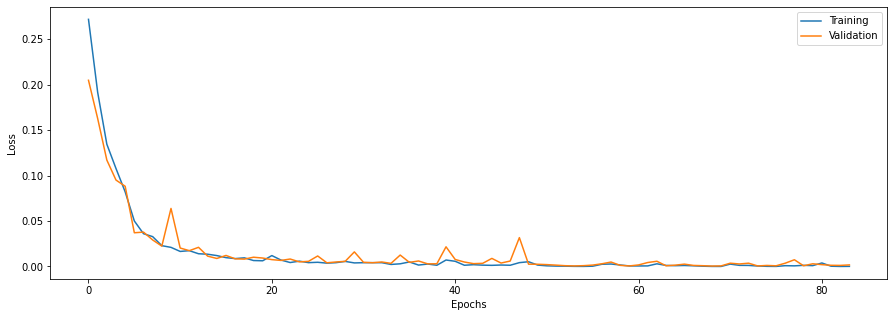

In [6]:
#takes some time, might need a GPU for this part
es = EarlyStopping(patience=15, min_delta=1e-4, verbose=2, restore_best_weights=True)
network_history = model.fit(X_train, Y_train,
          batch_size=512,
          epochs=100,
          verbose=2,
          validation_data=(X_valid,Y_valid),
          callbacks=[es],
          shuffle= True)
#some feedback
plt.figure(figsize=(15,5))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(network_history.history['loss'])
plt.plot(network_history.history['val_loss'])
plt.legend(['Training', 'Validation']);

## Evaluation on test data
Evaluate the model on the test data in terms of loss and accuracy.

In [7]:
loss, acc = model.evaluate(X_test,Y_test, verbose = 0)
y_pred = model.predict(X_test)
print(f'test loss: {loss}')
print(f'test accuracy: {acc}')

test loss: 0.0025497921742498875
test accuracy: 0.9996012449264526


## Confusion matrix
Calculate and display the confusion matrix.


Confusion matrix: 


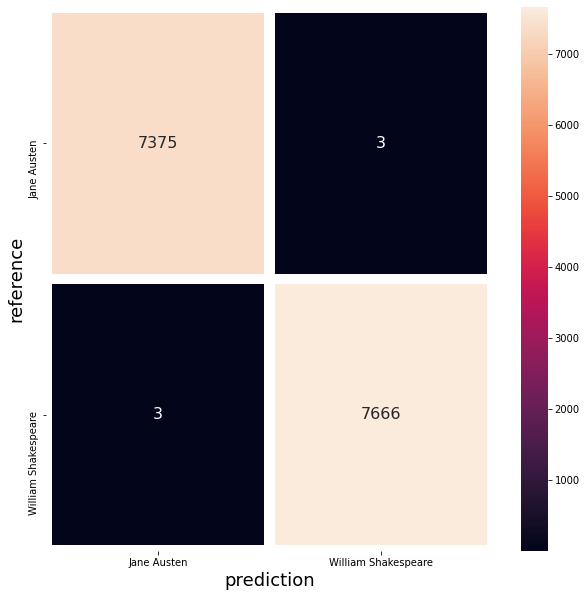

Predicted Jane, but its William's
0: oyalties. special rules, set forth in thegeneral terms of use part of this license, apply 
1: s will replace the previous one--the old editions will berenamed.creating the works from p
2: her part of the islandenter alonso, sebastian, antonio, gonzalo, adrian, francisco, andoth
Predicted William, but its Jane's
0:  read asfollows:                                    “bond street, january.        my dear 
1:    spared, had not my character required it to be written and read.     you must, therefor
2: our    brother has gained my affections entirely, and as we could not live    without one 


In [11]:
y_pred = np.rint(y_pred.reshape(Y_test.size)) #convert guesses to labels
y_true = Y_test

print("\nConfusion matrix: ")
conf=confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,10))
sns.heatmap(conf, annot=True, fmt='d', annot_kws={"size": 16}, linewidth=10,
            yticklabels=num_author.values(),
            xticklabels=num_author.values())
plt.xlabel("prediction", fontsize=18) 
plt.ylabel("reference", fontsize=18)
plt.show()

#show problematic cases
FP = []
FN = []
TP = []
TN = []
for i in range(y_true.size):  #sort indexes to confusion matrix categories
  if y_pred[i] == 0:
    if y_true[i] == 0:
      TN.append(i)
    else:
      FN.append(i)
  else:
    if y_true[i] == 1:
      TP.append(i)
    else:
      FP.append(i)
def onehotToText(oneHotSentence):
  sentence = ''
  for onehotChar in oneHotSentence:
    index = np.argmax(onehotChar)
    sentence += indices_char[index]
  return sentence
print("Predicted Jane, but its William's")
for i, oneHotSentence in enumerate(X_test[FN]):
  print(f'{i}: {onehotToText(oneHotSentence)}')
print("Predicted William, but its Jane's")
for i, oneHotSentence in enumerate(X_test[FP]):
  print(f'{i}: {onehotToText(oneHotSentence)}')